Using 15 tickers: ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY']...
3/7  σ=1.8933  Profit=0.7220  Weekly=0.0107
7/7  σ=1.8771  Profit=52.7755  Weekly=0.7827
15/7  σ=1.9526  Profit=78.3408  Weekly=1.1618
30/7  σ=1.9415  Profit=130.2061  Weekly=1.9310


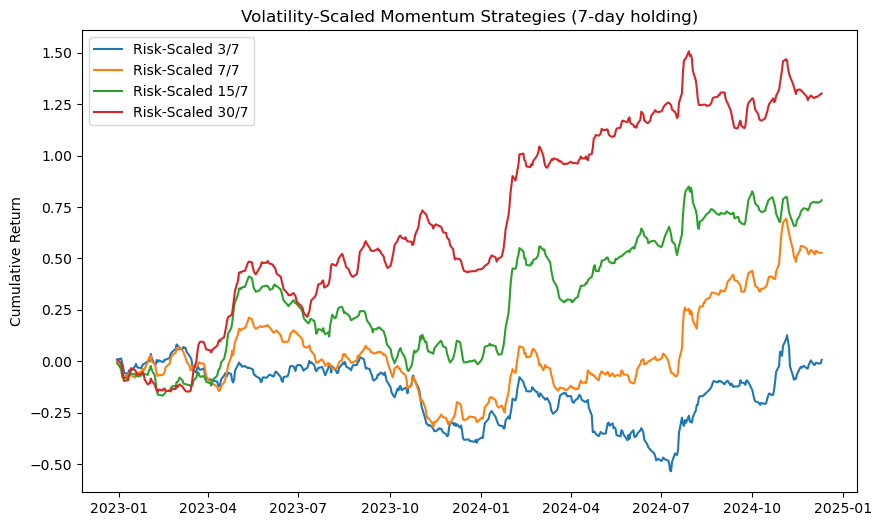

In [1]:
# Risk-Scaled (Volatility-Adjusted) Momentum Strategy
# ---------------------------------------------------
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# ----------------------------
# Configuration
# ----------------------------
DATA_DIR = r"C:\Users\cooki\OneDrive\Uni\Seminar Econ in financial application\by_ticker_csv"
TICKERS = ['ABBV', 'AMGN', 'AZN', 'BIIB', 'BMY', 'GILD', 'GSK',
           'JNJ', 'LLY', 'MRK', 'NVO', 'NVS', 'PFE', 'RHHBY', 'SNY']
START = datetime.datetime(2015, 1, 2)
END   = datetime.datetime(2024, 12, 31)
K = 7  # Holding period in days (weekly rebalance)

# ----------------------------
# Data Loading
# ----------------------------
def list_available_tickers():
    if not os.path.isdir(DATA_DIR):
        raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")
    return sorted([os.path.splitext(f)[0] for f in os.listdir(DATA_DIR) if f.lower().endswith(".csv")])

def load_ticker_data(ticker, start=None, end=None):
    path = os.path.join(DATA_DIR, f"{ticker}.csv")
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date")
    if start: df = df[df["Date"] >= pd.Timestamp(start)]
    if end: df = df[df["Date"] <= pd.Timestamp(end)]
    df["Adj Close"] = df["Close"]
    df["Ticker"] = ticker
    return df

def get_data(tickers, start=None, end=None):
    return pd.concat([load_ticker_data(t, start, end) for t in tickers])

# ----------------------------
# Feature Preparation
# ----------------------------
def prep_data_volscaled(tickers, start=None, end=None, K=7):
    all_data = get_data(tickers, start, end)

    daily_close_px = (
        all_data.pivot(index="Date", columns="Ticker", values="Adj Close")
        .sort_index()
    )
    daily_pct_change = daily_close_px.pct_change()

    dly_vars = all_data[["Date", "Ticker", "Adj Close", "Volume"]].rename(columns={"Adj Close": "Price"})
    dly_vars["t-1"] = 0.0
    dly_vars["target"] = 0.0

    for coin in tickers:
        sel = dly_vars["Ticker"] == coin
        prices = dly_vars.loc[sel, "Price"]
        dly_vars.loc[sel, "t-1"] = prices.pct_change().shift(1)

        # Compute rolling momentum, vol, and risk-adjusted momentum
        for J in (3,7,15,30):
            mom = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).apply(np.prod, raw=True) - 1
            vol = (1 + dly_vars.loc[sel, "t-1"]).rolling(J).std()
            dly_vars.loc[sel, f"J_{J}"] = mom
            dly_vars.loc[sel, f"J_std_{J}"] = vol
            dly_vars.loc[sel, f"J_riskadj_{J}"] = mom / (vol + 1e-8)  # avoid div by 0

        # Target forward return
        dly_vars.loc[sel, "target"] = prices.shift(-K) / prices - 1

    dly_vars = dly_vars.dropna().reset_index(drop=True)
    dly_data = dly_vars.set_index("Date")
    dly_target = dly_vars["target"].values
    return dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target

# ----------------------------
# Train/test split
# ----------------------------
def train_test_split(dly_data, daily_close_px, test_ratio=0.2):
    all_dates = sorted(set(dly_data.index).intersection(set(daily_close_px.index)))
    cutoff = int(len(all_dates) * (1 - test_ratio))
    dates_train = pd.Index(all_dates[:cutoff])
    dates_test  = pd.Index(all_dates[cutoff:])

    X_train_df = dly_data.loc[dates_train]
    X_test_df  = dly_data.loc[dates_test]

    data_train = X_train_df.copy()
    data_test  = X_test_df.copy()

    def split_xy(df):
        X = df.reset_index(drop=False)
        y = X["target"].copy()
        X = X.drop(columns=["target","Price","Ticker","Date"], errors="ignore")
        return X, y

    X_train, y_train = split_xy(X_train_df)
    X_test, y_test = split_xy(X_test_df)

    def _reset_with_date(df):
        out = df.reset_index()
        if "Date" not in out.columns and "index" in out.columns:
            out = out.rename(columns={"index":"Date"})
        return out

    return X_train, y_train, X_test, y_test, _reset_with_date(data_train), _reset_with_date(data_test)

# ----------------------------
# Strategy Functions
# ----------------------------
def Momentum(pred_r, date, K, daily_close_px):
    ret = pred_r.loc[date].reset_index()
    ret["quantile"] = pd.qcut(ret.iloc[:, 1].rank(method="first"), 3, labels=False)
    winners = ret[ret["quantile"] == 2]
    losers  = ret[ret["quantile"] == 0]
    next_date = date + relativedelta(days=K)
    if next_date not in daily_close_px.index:
        return np.nan, np.nan, np.nan
    w = daily_close_px.loc[next_date, daily_close_px.columns.isin(winners.Ticker)] / \
        daily_close_px.loc[date, daily_close_px.columns.isin(winners.Ticker)] - 1
    l = daily_close_px.loc[next_date, daily_close_px.columns.isin(losers.Ticker)] / \
        daily_close_px.loc[date, daily_close_px.columns.isin(losers.Ticker)] - 1
    mom_profit = w.mean() - l.mean()
    return (mom_profit / K * 7), (w.mean() / K * 7), (-l.mean() / K * 7)

def MOM_Profit(returns, K, daily_close_px):
    profits, wins, loss, dates = [], [], [], []
    for date in returns.index[:-K]:
        mom, win, los = Momentum(returns, date, K, daily_close_px)
        if np.isnan(mom): continue
        profits.append(mom); wins.append(win); loss.append(los); dates.append(date)
    frame = pd.DataFrame({'MomentumProfit': profits, 'Winners': wins, 'Losers': loss}, index=dates) * 100
    cum_frame = frame.cumsum()
    profit = frame.MomentumProfit.sum()
    return frame, cum_frame, profit

def RISK_SCALED_MOM(K, data_test, daily_close_px):
    """Run volatility-scaled momentum."""
    if "Date" not in data_test.columns:
        data_test = data_test.reset_index().rename(columns={"index":"Date"})
    out = {}
    for J in (3,7,15,30):
        R = data_test.pivot(index="Date", columns="Ticker", values=f"J_riskadj_{J}")
        frame, cum_frame, prof = MOM_Profit(R, K, daily_close_px)
        print(f'{J}/{K}  σ={frame.MomentumProfit.std():.4f}  Profit={prof:.4f}  '
              f'Weekly={frame.MomentumProfit.mean()*7:.4f}')
        out[J] = (frame, cum_frame, prof)
    return out

# ----------------------------
# Run Strategy
# ----------------------------
all_tickers = list_available_tickers()
tickers = TICKERS or all_tickers
print(f"Using {len(tickers)} tickers: {tickers[:5]}...")

dly_vars, dly_data, daily_pct_change, daily_close_px, dly_target = prep_data_volscaled(tickers, start=START, end=END, K=K)
X_train, y_train, X_test, y_test, data_train, data_test = train_test_split(dly_data, daily_close_px)

# Run volatility-scaled momentum
results_risk = RISK_SCALED_MOM(K, data_test, daily_close_px)

# Plot cumulative returns
fig, ax = plt.subplots(figsize=(10,6))
for J in (3,7,15,30):
    ax.plot(results_risk[J][1].MomentumProfit/100, label=f"Risk-Scaled {J}/{K}")
ax.legend()
ax.set_ylabel("Cumulative Return")
ax.set_title(f"Volatility-Scaled Momentum Strategies ({K}-day holding)")
plt.show()
